# Quickstart Example with Open Bandit Pipeline
---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy using some OPE estimators and logged bandit feedback generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. It also implements the data-driven evaluation and comparison of different OPE estimators.

Our example with the Open Bandit Dataset contains the following four major steps:
- (1) Data Loading and Preprocessing
- (2) Production Policy Replicatin
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

In [1]:
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
import obp
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.4.0


## (1) Data Loading and Preprocessing

We prepare easy-to-use data loader for Open Bandit Dataset, `OpenBanditDataset` class in the dataset module. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [3]:
# (1) Data loading and preprocessing
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')
# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the example small-sized version of the Open Bandit Dataset.


dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

### let's see some properties of the dataset class

In [4]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [5]:
# number of actions of the "All" campaign is 80
dataset.n_actions

80

In [6]:
# small sample example data has 10,000 rounds
dataset.n_rounds

10000

In [7]:
# default context (feature) engineering creates context vector with 20 dimensions
dataset.dim_context

20

In [8]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

## (2) Production Policy Replication

After preparing the dataset, we now replicate the BernoulliTS policy implemented on the ZOZOTOWN recommendation interface during the data collection period.

Here, we use **Bernoulli TS** implemented in the policy module as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate (the policy parameters of) BernoulliTS used in ZOZOTOWN production.
(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

In [9]:
# (2) Production Policy Replication
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list, 
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)
# compute the action choice probabilities by the evaluation policy using Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

# action_dist is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the evaluation policy
action_dist

array([[[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       ...,

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
  

## (3) Off-Policy Evaluation (OPE)

Our next step is **OPE**, which attempts to estimate the performance of new decision making policies using log data generated by behavior, past policies. 

We use the *InverseProbabilityWeighting (IPW)*, *DirectMethod (DM)*, and *Doubly Robust (DR)* estimators and estimate the performance of Bernoulli TS using the logged bandit feedback. 

Then, we summarize and visualize the OPE results.

In [10]:
# estimate the mean reward function by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LogisticRegression(random_state=12345),
)
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

/Users/usaito/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/usaito/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [11]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure.
    random_state=12345,
)

In [12]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy 
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004553,1.198126
dm,0.003385,0.890885
dr,0.004647,1.222970


In [13]:
# estimated confidence intervals of policy value of BernoulliTS by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure 
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004544,0.001531,0.009254
dm,0.003385,0.003338,0.003433
dr,0.004638,0.001625,0.009322


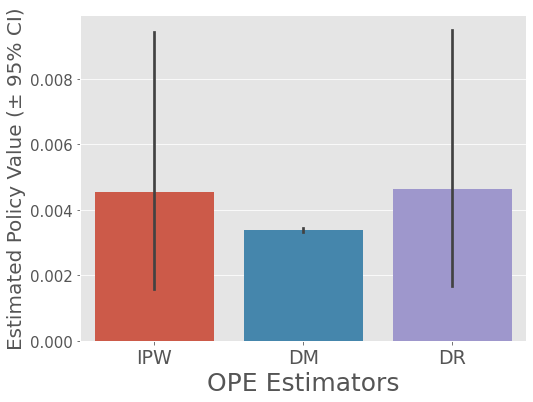

In [14]:
# visualize the estimated policy values of BernoulliTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

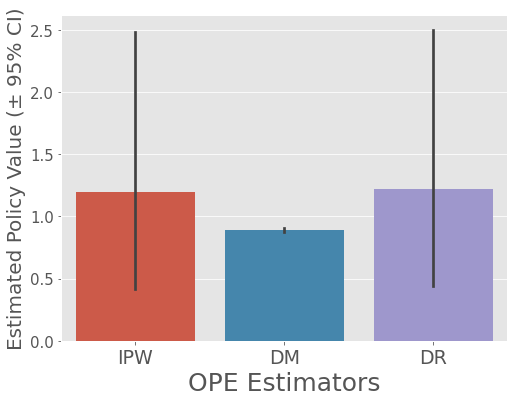

In [15]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 
Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.

## (4) Evaluation of OPE

Our final step is the **evaluation of OPE**, which evaluates the estimation accuracy of OPE estimators.

Specifically, we asses the accuracy of the estimator such as DM, IPW, and DR by comparing its estimation with the ground-truth policy value estimated via the on-policy estimation from the Open Bandit Dataset.
This type of data-driven evaluation of OPE is possible, because the Open Bandit Dataset contains a set of *multiple* different logged bandit feedback datasets collected by running different policies on the same platform at the same time.

Please refer to [the documentation](https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html) for the details about the evaluation of OPE protocol.

In [16]:
# we first calculate the ground-truth policy value of the evaluation policy
# , which is estimated by averaging the factual (observed) rewards contained in the dataset (on-policy estimation)
policy_value_bts = OpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy='bts', campaign='all'
)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the example small-sized version of the Open Bandit Dataset.


In [17]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of BernoulliTS and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee

,relative-ee
ipw,0.084019
dm,0.193961
dr,0.106497


Please see [examples/obd](../obd) for a more sophisticated example of the evaluation of OPE with the Open Bandit Dataset.